In [29]:
# Block 1: Basic Setup and Imports
import os
import sys
from datetime import datetime

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *


# Create Spark Session
spark = SparkSession.builder \
    .appName("Bank Marketing Analysis") \
    .master("local[*]") \
    .getOrCreate()

# Print setup information
print(f"PySpark Version: {spark.version}")
print(f"Current user: {os.getenv('USER')}")
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

PySpark Version: 3.5.4
Current user: liran
Analysis started at: 2025-01-30 17:26:01


In [30]:
# Block 2: Load Data
# Simple data loading function
def load_data(file_path):
    """Load CSV file and print basic information"""
    df = spark.read.csv(file_path, 
                       header=True, 
                       inferSchema=True)
    
    print(f"\nData loaded successfully!")
    print(f"Number of rows: {df.count()}")
    print(f"Number of columns: {len(df.columns)}")
    print("\nSchema:")
    df.printSchema()
    print("\nFirst 5 rows:")
    df.show(5)
    
    return df

# Load the bank data
bank_df = load_data('bank.csv')


Data loaded successfully!
Number of rows: 11162
Number of columns: 17

Schema:
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)


First 5 rows:
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previ

Print 10 random rows
Using sample() function with a fraction to get random rows


In [31]:
random_rows = bank_df.sample(fraction=0.1, seed=42) \
                    .limit(10)

print("10 Random Rows from the Bank Dataset:")
random_rows.show(truncate=False)  # truncate=False shows full content of each column

10 Random Rows from the Bank Dataset:
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job        |marital |education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|60 |retired    |divorced|secondary|no     |545    |yes    |no  |unknown|6  |may  |1030    |1       |-1   |0       |unknown |yes    |
|32 |blue-collar|single  |primary  |no     |611    |yes    |no  |unknown|8  |may  |541     |3       |-1   |0       |unknown |yes    |
|41 |admin.     |married |secondary|no     |55     |yes    |no  |unknown|8  |may  |1120    |2       |-1   |0       |unknown |yes    |
|41 |blue-collar|single  |primary  |no     |1618   |yes    |no  |unknown|14 |may  |1553    |1       |-1   |0       |unknown |yes    |
|40 |technician |single 

elative proportions of no and yes for deposit feature

In [35]:
from pyspark.sql.functions import desc, col, round

# First, let's analyze deposit distribution
print("Deposit Distribution:")
deposit_dist = bank_df.groupBy("deposit") \
    .count() \
    .withColumn("percentage", round(col("count") / bank_df.count() * 100, 2)) \
    .orderBy("deposit")

deposit_dist.show()

# List of categorical columns to analyze
categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]

# Function to calculate distribution for each categorical variable
def get_category_distribution(df, column_name):
    return df.groupBy(column_name) \
        .count() \
        .withColumn("percentage", round(col("count") / df.count() * 100, 2)) \
        .orderBy(desc("count"))

# Print distribution for each categorical variable
print("\nDistribution of Categorical Variables:")
for column_name in categorical_cols:
    print(f"\n{column_name.upper()} Distribution:")
    get_category_distribution(bank_df, column_name).show()

# Analyze deposit distribution by job
print("\nDeposit Distribution by Job:")
bank_df.groupBy("job", "deposit") \
    .count() \
    .orderBy("job", "deposit") \
    .show()




Deposit Distribution:
+-------+-----+----------+
|deposit|count|percentage|
+-------+-----+----------+
|     no| 5873|     52.62|
|    yes| 5289|     47.38|
+-------+-----+----------+


Distribution of Categorical Variables:

JOB Distribution:
+-------------+-----+----------+
|          job|count|percentage|
+-------------+-----+----------+
|   management| 2566|     22.99|
|  blue-collar| 1944|     17.42|
|   technician| 1823|     16.33|
|       admin.| 1334|     11.95|
|     services|  923|      8.27|
|      retired|  778|      6.97|
|self-employed|  405|      3.63|
|      student|  360|      3.23|
|   unemployed|  357|       3.2|
| entrepreneur|  328|      2.94|
|    housemaid|  274|      2.45|
|      unknown|   70|      0.63|
+-------------+-----+----------+


MARITAL Distribution:
+--------+-----+----------+
| marital|count|percentage|
+--------+-----+----------+
| married| 6351|      56.9|
|  single| 3518|     31.52|
|divorced| 1293|     11.58|
+--------+-----+----------+


EDUCAT

In [36]:
# List of numerical columns
numerical_cols = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]

# Get basic statistics for numerical columns
print("Basic Statistics for Numerical Variables:")
bank_df.select(numerical_cols).describe().show()

# Get more detailed statistics including additional metrics
from pyspark.sql.functions import mean, stddev, min, max, count, skewness, kurtosis, percentile_approx

def detailed_numeric_stats(df, column):
    stats = df.agg(
        count(column).alias('count'),
        mean(column).alias('mean'),
        stddev(column).alias('std'),
        min(column).alias('min'),
        percentile_approx(column, 0.25).alias('25%'),
        percentile_approx(column, 0.5).alias('median'),
        percentile_approx(column, 0.75).alias('75%'),
        max(column).alias('max'),
        skewness(column).alias('skewness'),
        kurtosis(column).alias('kurtosis')
    ).collect()[0]
    
    return stats

print("\nDetailed Statistics for each Numerical Variable:")
for col in numerical_cols:
    stats = detailed_numeric_stats(bank_df, col)
    print(f"\n{col.upper()} Statistics:")
    print(f"Count: {stats['count']}")
    print(f"Mean: {stats['mean']:.2f}")
    print(f"Std: {stats['std']:.2f}")
    print(f"Min: {stats['min']}")
    print(f"25%: {stats['25%']}")
    print(f"Median: {stats['median']}")
    print(f"75%: {stats['75%']}")
    print(f"Max: {stats['max']}")
    print(f"Skewness: {stats['skewness']:.2f}")
    print(f"Kurtosis: {stats['kurtosis']:.2f}")

# Additional analysis: Count of null values if any
print("\nNull Values Count in Numerical Columns:")
for col in numerical_cols:
    null_count = bank_df.filter(bank_df[col].isNull()).count()
    print(f"{col}: {null_count}")

Basic Statistics for Numerical Variables:
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|           balance|               day|          duration|          campaign|             pdays|          previous|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             11162|             11162|             11162|             11162|             11162|             11162|             11162|
|   mean|41.231947679627304|1528.5385235620856|15.658036194230425|371.99381831213043| 2.508421429851281| 51.33040673714388|0.8325568894463358|
| stddev|11.913369192215518| 3225.413325946149| 8.420739541006462|347.12838571630687|2.7220771816614824|108.75828197197717| 2.292007218670508|
|    min|                18|             -6847|                 1|                 2|               

visualization

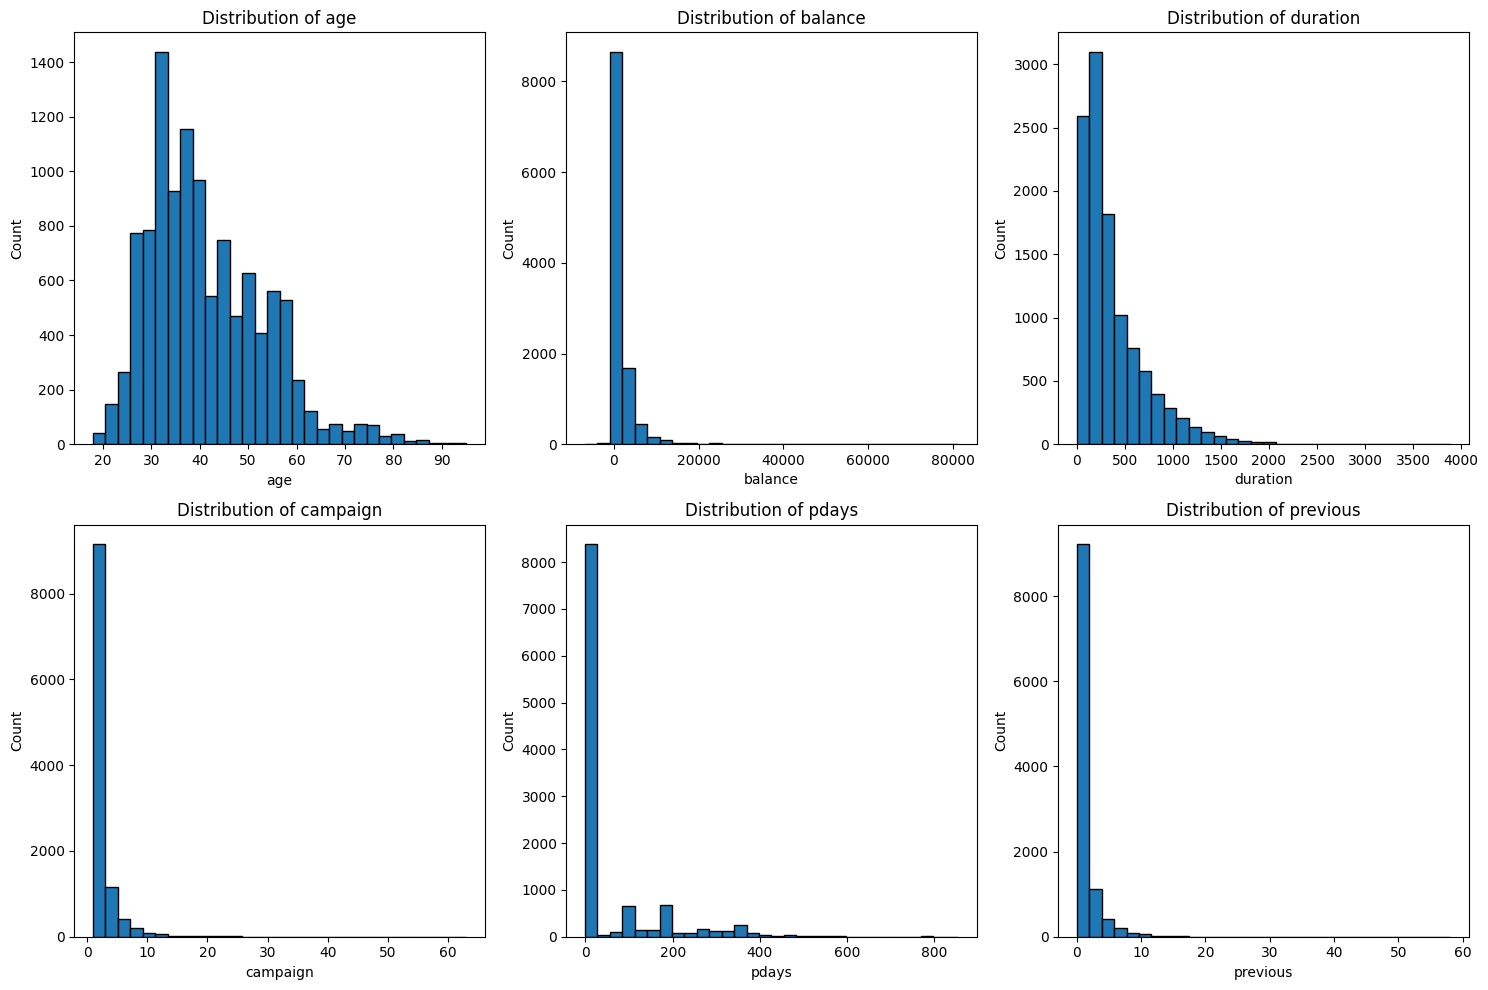

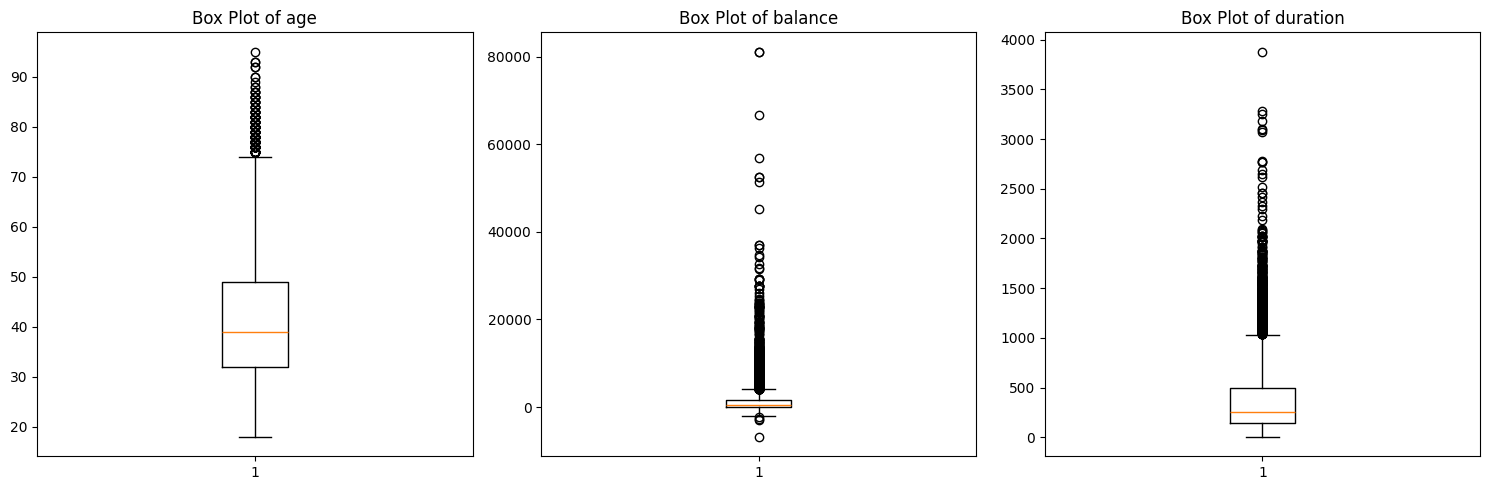

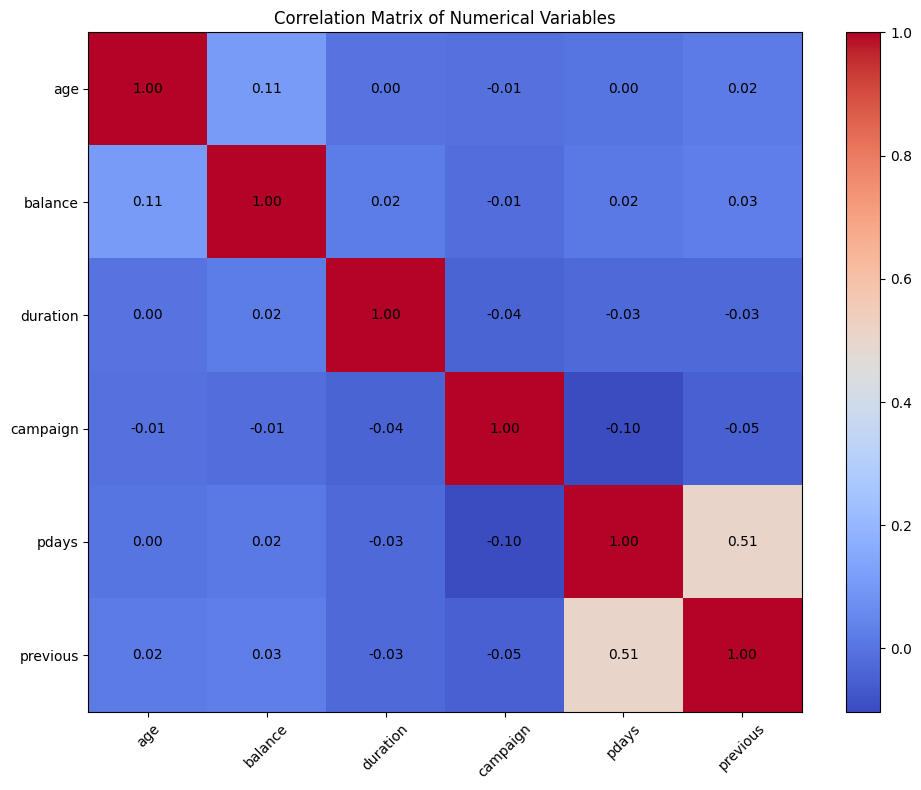

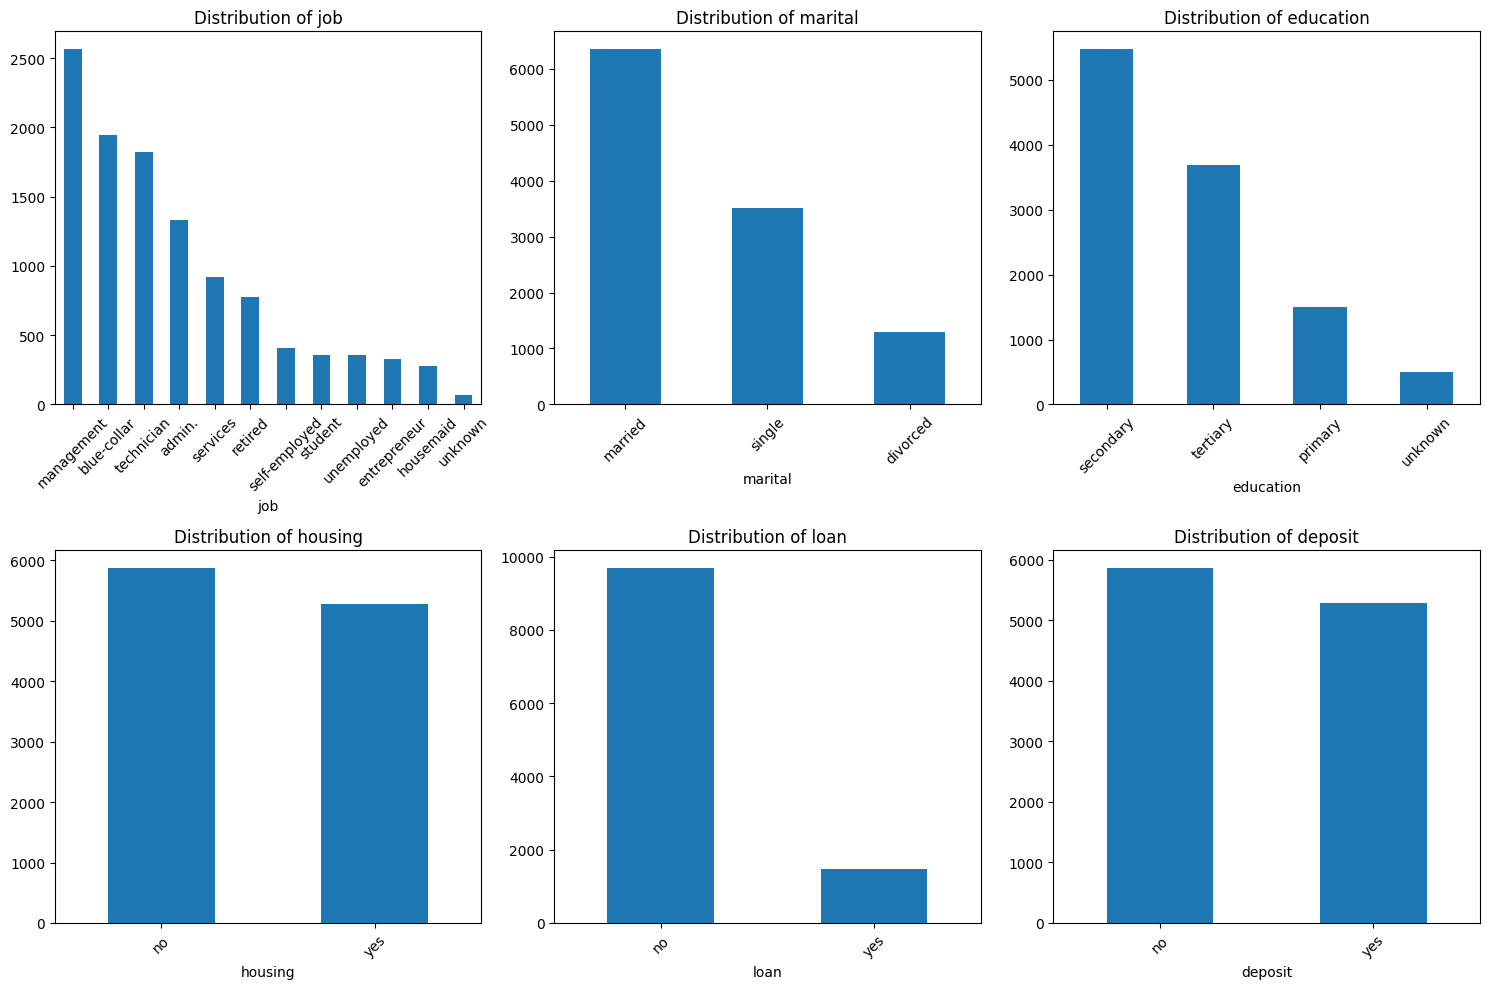

/tmp/ipykernel_37831/3316496257.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


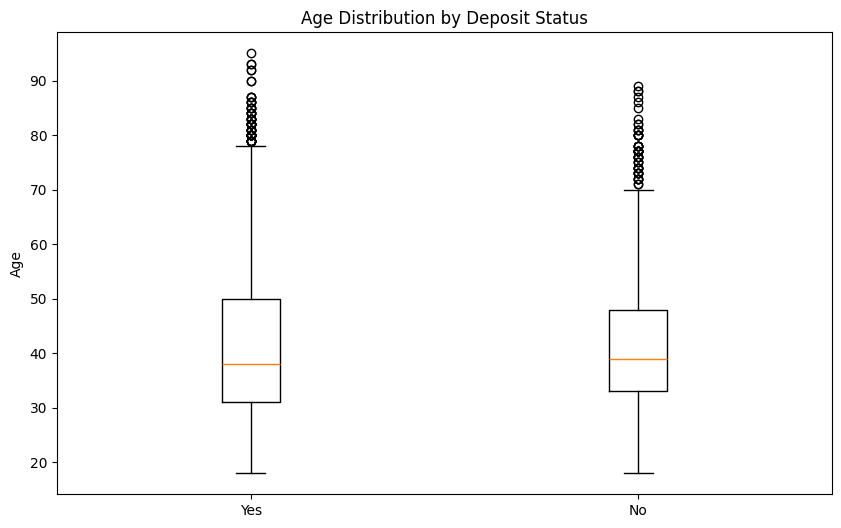


Key Statistical Insights:

1. Deposit Success Rate:
Overall deposit success rate: 47.38%

2. Average balance by education level:
education
tertiary     1845.869070
unknown      1746.605634
primary      1523.031333
secondary    1296.480278
Name: balance, dtype: float64

3. Age statistics by deposit status:
          mean    std
deposit              
no       40.84  10.26
yes      41.67  13.50

4. Top correlations with deposit success:
deposit_bool    1.000000
duration        0.451919
pdays           0.151593
previous        0.139867
balance         0.081129
age             0.034901
campaign       -0.128081
Name: deposit_bool, dtype: float64


In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert Spark DataFrame to Pandas for visualization
pandas_df = bank_df.toPandas()

# 1. Numerical Variables Distributions
plt.figure(figsize=(15, 10))
numerical_cols = ["age", "balance", "duration", "campaign", "pdays", "previous"]

for idx, col in enumerate(numerical_cols):
    plt.subplot(2, 3, idx+1)
    plt.hist(pandas_df[col], bins=30, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2. Box plots for key numerical variables
plt.figure(figsize=(15, 5))
numerical_for_box = ["age", "balance", "duration"]
for idx, col in enumerate(numerical_for_box):
    plt.subplot(1, 3, idx+1)
    plt.boxplot(pandas_df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

# 3. Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = pandas_df[numerical_cols].corr()
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=45)
plt.yticks(range(len(numerical_cols)), numerical_cols)
plt.title('Correlation Matrix of Numerical Variables')
for i in range(len(numerical_cols)):
    for j in range(len(numerical_cols)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center')
plt.tight_layout()
plt.show()

# 4. Bar plots for categorical variables
categorical_cols = ['job', 'marital', 'education', 'housing', 'loan', 'deposit']
plt.figure(figsize=(15, 10))
for idx, col in enumerate(categorical_cols):
    plt.subplot(2, 3, idx+1)
    pandas_df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Age distribution by deposit status
plt.figure(figsize=(10, 6))
plt.boxplot([
    pandas_df[pandas_df['deposit'] == 'yes']['age'],
    pandas_df[pandas_df['deposit'] == 'no']['age']
], labels=['Yes', 'No'])
plt.title('Age Distribution by Deposit Status')
plt.ylabel('Age')
plt.show()

# Print key insights
print("\nKey Statistical Insights:")

print("\n1. Deposit Success Rate:")
deposit_rate = (pandas_df['deposit'] == 'yes').mean() * 100
print(f"Overall deposit success rate: {deposit_rate:.2f}%")

print("\n2. Average balance by education level:")
education_balance = pandas_df.groupby('education')['balance'].mean().sort_values(ascending=False)
print(education_balance)

print("\n3. Age statistics by deposit status:")
age_by_deposit = pandas_df.groupby('deposit')['age'].agg(['mean', 'std']).round(2)
print(age_by_deposit)

print("\n4. Top correlations with deposit success:")
deposit_numeric = pandas_df.copy()
deposit_numeric['deposit_bool'] = (deposit_numeric['deposit'] == 'yes').astype(int)
correlations = deposit_numeric[numerical_cols + ['deposit_bool']].corr()['deposit_bool'].sort_values(ascending=False)
print(correlations)